https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data

In [78]:
import struct
import numpy as np

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims= struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def load_mnist(image_path, label_path):
    images = read_idx(image_path)
    labels = read_idx(label_path)
    return images, labels

train_image_path = '../data/train-images-idx3-ubyte/train-images-idx3-ubyte'
train_label_path = '../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_image_path =  '../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_label_path =  '../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

train_images, train_labels = load_mnist(train_image_path, train_label_path)
test_images, test_labels = load_mnist(test_image_path, test_label_path)
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


output label = 1


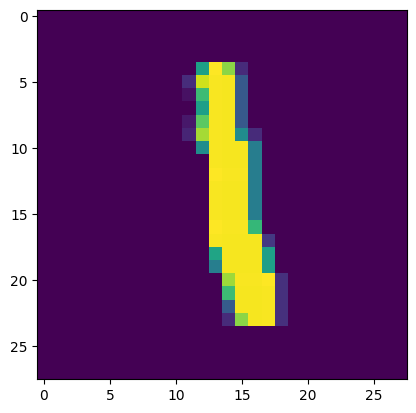

In [79]:
#familiarize ourselves with the data
import matplotlib.pyplot as plt

index = 6
plt.imshow(train_images[index])
print("output label =",train_labels[index])

In [80]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
class ColeNet(torch.nn.Module):
  def __init__(self):
    super(ColeNet, self).__init__()
    #y = 128(784(mx) + b)
    self.l1 = nn.Linear(784, 128, bias=False)
    #y = 10(128(mx) + b)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x


In [81]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = ColeNet()
count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   100352   |
| l2.weight |    1280    |
+-----------+------------+
Total Trainable Params: 101632


101632

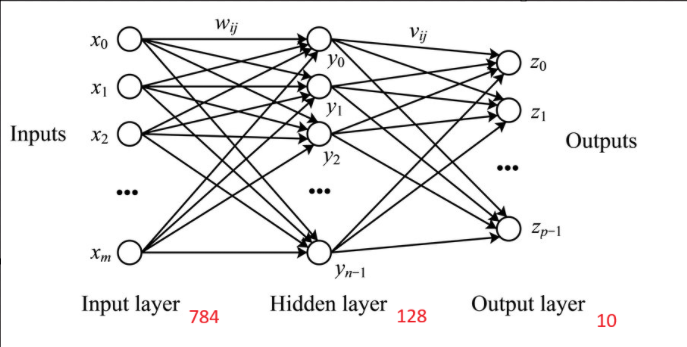

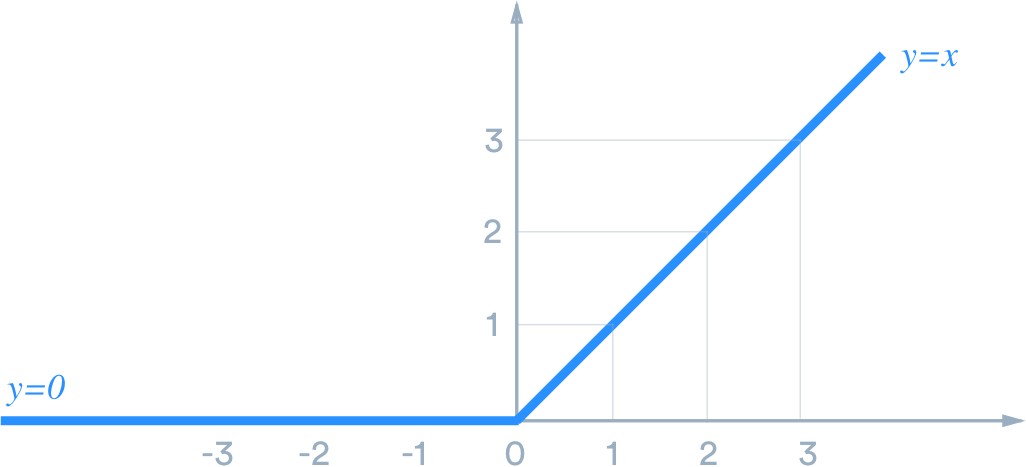

loss 0.28 accuracy 0.91: 100%|██████████| 1000/1000 [00:01<00:00, 597.88it/s]


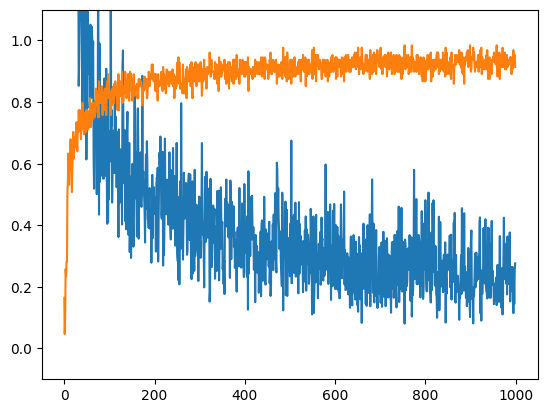

In [82]:
import matplotlib.pyplot as plt
from tqdm import trange

model = ColeNet()

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, train_images.shape[0], size=(BS))
  X = torch.tensor(train_images[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(train_labels[samp]).long()
  #(128,784)
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [83]:
Y_test_preds = torch.argmax(model(torch.tensor(test_images.reshape((-1, 28*28))).float()), dim=1).numpy()
(test_labels == Y_test_preds).mean()

0.9204

output label = 7


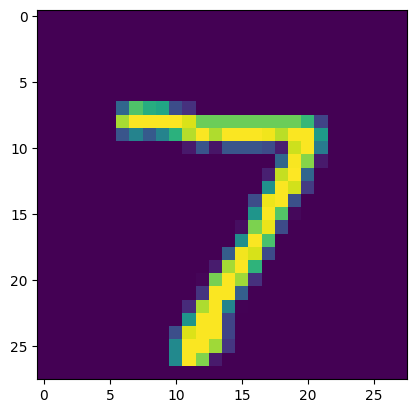

In [84]:
plt.imshow(test_images[0])
print("output label =",test_labels[0])

In [85]:
torch.argmax(model(torch.tensor(test_images[0]).reshape(-1,28*28).float()))

tensor(7)

In [86]:
image_index = 0

2

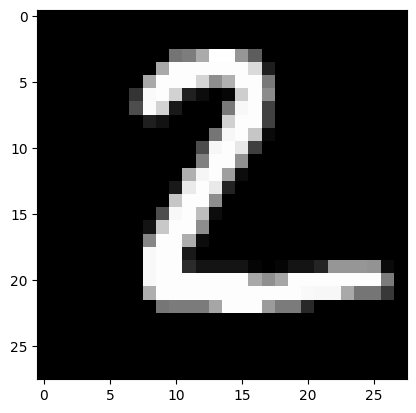

In [87]:
image_index += 1 

plt.imshow(test_images[image_index], cmap='gray')
test_labels[image_index]
torch.argmax(model(torch.tensor(test_images[image_index]).reshape(-1,28 * 28).float())).item()

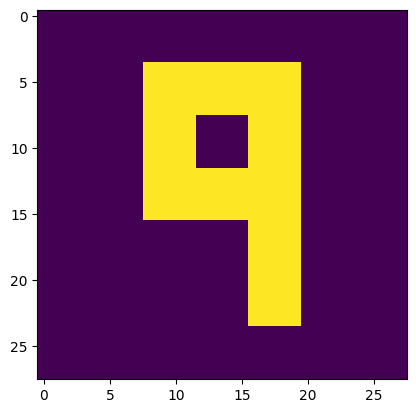

In [88]:
# for fun, can it recognize 4?
eight = [[0,0,0,0,0,0,0],
        [0,0,1,1,1,0,0],
        [0,0,1,0,1,0,0],
        [0,0,1,1,1,0,0],
        [0,0,1,0,1,0,0],
        [0,0,1,1,1,0,0],
        [0,0,0,0,0,0,0]]
four = [[0,0,0,0,0,0,0],
       [0,0,1,0,1,0,0],
       [0,0,1,0,1,0,0],
       [0,0,1,1,1,1,0],
       [0,0,0,0,1,0,0],
       [0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0]]
nine = [[0,0,0,0,0,0,0],
       [0,0,1,1,1,0,0],
       [0,0,1,0,1,0,0],
       [0,0,1,1,1,0,0],
       [0,0,0,0,1,0,0],
       [0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0]]
# upscale to 28x28
m = nine
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))

In [89]:
print("the image is a:", torch.argmax(model(torch.Tensor(m).reshape(-1,28 * 28))).numpy().item())

the image is a: 8
